In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import cv2

In [14]:
path = 'C:/dataset'

In [15]:
categories = ['train', 'test', 'val', 'auto_test'] # 전처리된 데이터셋을 훈련용, 평가용, 검증용으로 구분
data_dir = path+'/osteoarthritis/'
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # Mac OS
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

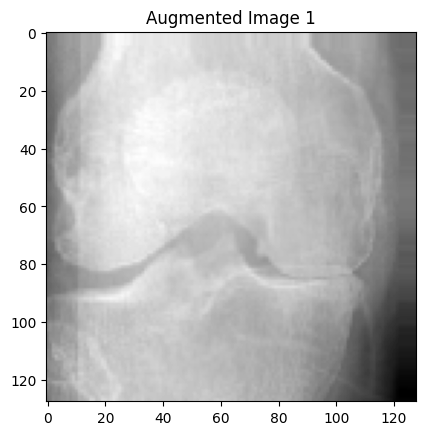

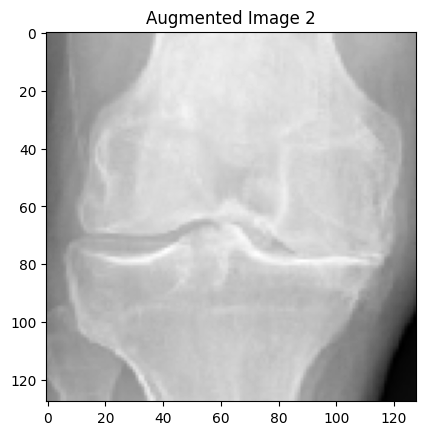

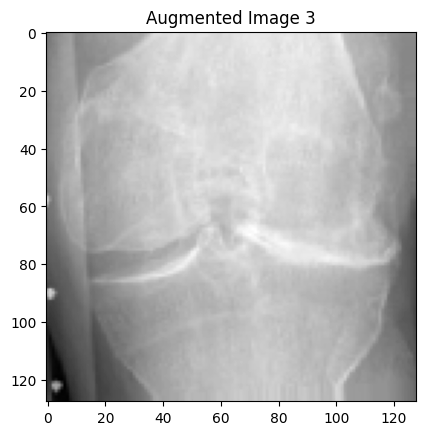

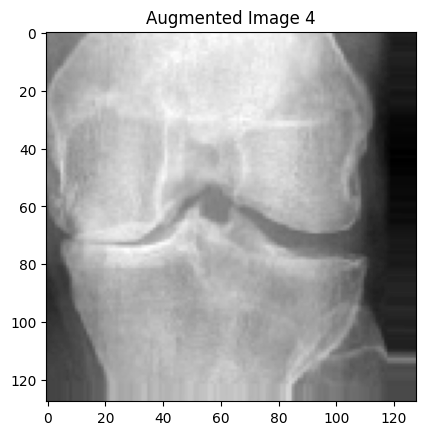

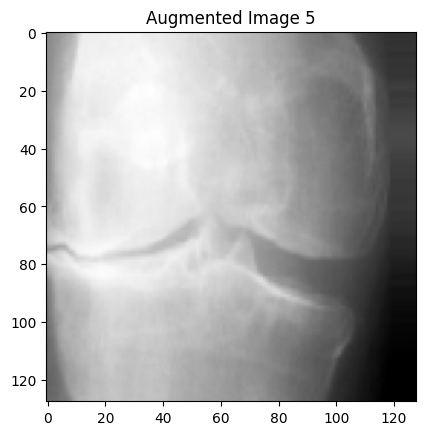

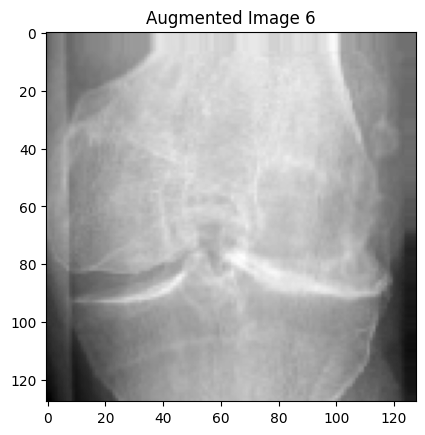

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

def augment_images(data_dir, label, augment_count=600):
    label_path = os.path.join(data_dir, 'train', str(label))
    augmented_dir = os.path.join(label_path, 'augmented')
    os.makedirs(augmented_dir, exist_ok=True)

    img_names = os.listdir(label_path)
    img_names = [name for name in img_names if os.path.isfile(os.path.join(label_path, name))]
    generated_count = 0

    while generated_count < augment_count:
        img_name = np.random.choice(img_names)
        img_path = os.path.join(label_path, img_name)
        try:
            img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
            img = img_to_array(img)
            img = img.reshape((1,) + img.shape)

            for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='png'):
                generated_count += 1
                break  # 한 장만 생성하고 반복문 탈출
        except PermissionError:
            print(f"Permission denied: Unable to access file {img_path}")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")

# Augment images in label 4
# data_dir = path+'/osteoarthritis/train/'  # 적절한 데이터 디렉토리로 변경
augment_images(data_dir, 4)

# Display augmented images
augmented_img_paths = os.listdir(os.path.join(data_dir, 'train', '4', 'augmented'))
augmented_img_paths = shuffle(augmented_img_paths)[:6]  # 무작위로 6개 선택

for i, img_name in enumerate(augmented_img_paths):
    img_path = os.path.join(data_dir, 'train', '4', 'augmented', img_name)
    img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
    plt.imshow(img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.show()
